Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [44]:
HYPERTRAINING = False
CV = 5
SCORING = 'r2'
AUTO_FEATURE_SELECT = 'backward'
# forward eher schlecht
#'neg_mean_squared_error'   nope
#r2 sehr gut -> 0.45
# 'explained_variance'
# HUBER
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "potential_center_back"
SAVE_MODEL_NAME = EXPERIEMENT_NAME
RUN_NAME = None
TARGET_OVERALL = 80

PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackle','shooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']


PLAYER_ATTRIBUTES = [ 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'FKAccuracy', 'LongPassing', 'BallControl',
                       'SprintSpeed', 'Agility','Composure', 'Defense',  
                      'ShotPower',  'Strength',  'Aggression', 'Interceptions',  
                      'StandingTackle', 'SlidingTackle']



In [45]:
%load_ext autoreload
%autoreload 2

import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")

find_and_append_module_path()

import os
import warnings
from datetime import datetime
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report

import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

from prediction_prime_overall.src.prepare import (
    add_features_raw,
    select_features
)
from prediction_prime_overall.src.eval import (
    plot_feature_importance,
    plot_shap_summary,
    plot_auc_curves,
    log_metrics_in_mlflow_regression,
    log_metrics_in_mlflow,
    log_feature_list_as_artifact
)
import prediction_prime_overall.config as CONFIG
from prediction_prime_overall.src.utils import *


mlflow.set_tracking_uri("file:///"+CONFIG.MLFLOW)
mlflow.set_experiment(EXPERIEMENT_NAME)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
New current directory: c:\Users\Robert\Documents\Projekte\statsfaction


<Experiment: artifact_location='file:///c:\\Users\\Robert\\Documents\\Projekte\\statsfaction\\prediction_prime_overall\\data\\mlflow/863669011077412321', creation_time=1702066152531, experiment_id='863669011077412321', last_update_time=1702066152531, lifecycle_stage='active', name='potential_center_back', tags={}>

### Get Data

In [46]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [47]:


# Step 1: Establish a database connection
conn = sqlite3.connect(CONFIG.DATABASE)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw(df_raw)

df_raw.head()


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,NaN,NaN,95.0,25.0,94.0,RW,0,1,1.0,13.0
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,NaN,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,84.0,35.0,91.0,20.0,78.0,RW,0,1,1.0,35.0
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,NaN,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,82.0,25.0,90.0,21.0,81.0,RW,0,1,1.0,25.0


# 

In [48]:
# df_raw["Potential"] = df_raw.Potential.astype('float')
# df_raw["max_potential"] = df_raw.max_potential.astype('float')

In [49]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'train', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [50]:
df = df[(df.central == 1)&(df.offense == -1)]

# Training nur auf High Potentials
df = df[df.max_potential>TARGET_OVERALL]

# nur Entwicklugnsfähige Spieler
df = df[df.prime_age>df.potential_age]
df = df[df.PrimeOverall>df.Overall]
df['target'] = df.PrimeOverall
df = df[df.potential_age<23]

print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
79.0    28
76.0    27
75.0    19
77.0    19
72.0    19
74.0    18
84.0    17
73.0    16
78.0    16
70.0    15
71.0    13
80.0    13
81.0    11
83.0     9
82.0     9
68.0     7
67.0     7
87.0     4
62.0     4
86.0     4
65.0     3
85.0     3
63.0     2
89.0     2
60.0     2
69.0     2
64.0     1
61.0     1
66.0     1
88.0     1
Name: count, dtype: int64


In [51]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
207865,Marquinhos,2014,19.0,19.0,28.0,89.0,89.0,78.0,88.0,88.0,train,CB
247263,E. Tapsoba,2021,21.0,21.0,22.0,88.0,88.0,78.0,81.0,81.0,test,CB
243715,W. Saliba,2020,18.0,18.0,22.0,88.0,88.0,71.0,84.0,84.0,test,CB
183285,M. Sakho,2011,20.0,20.0,26.0,88.0,88.0,76.0,82.0,82.0,drop,CB
178603,M. Hummels,2011,21.0,21.0,29.0,88.0,88.0,79.0,89.0,89.0,drop,CB


In [52]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [53]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Marking', 'Att. Position', 'Composure', 'Defensive awareness'], dtype='object')

#### Transform Value

In [54]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

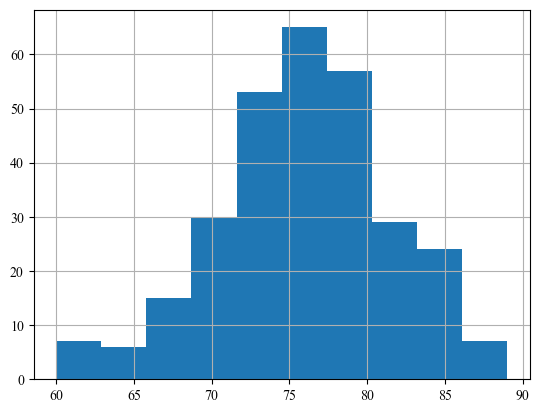

In [55]:
df['target'].hist()

In [56]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [57]:
df_processed.columns

Index(['potential_age', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Position', 'Unnamed: 0', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Att. Position', 'Composure', 'Defensive awareness', 'max_potential',
       'prime_age', 'PrimeOverall', 'best_position', 'central', 'winger',
       'offense', 'Defense', 'set', 'target'],
      dtype='object')

In [58]:
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [59]:
y_train.describe()

count    149.000000
mean      77.281879
std        4.894951
min       60.000000
25%       75.000000
50%       77.000000
75%       80.000000
max       88.000000
Name: target, dtype: float64

In [60]:


# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')


# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [61]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


In [62]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


In [63]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Ridge Regression training----->


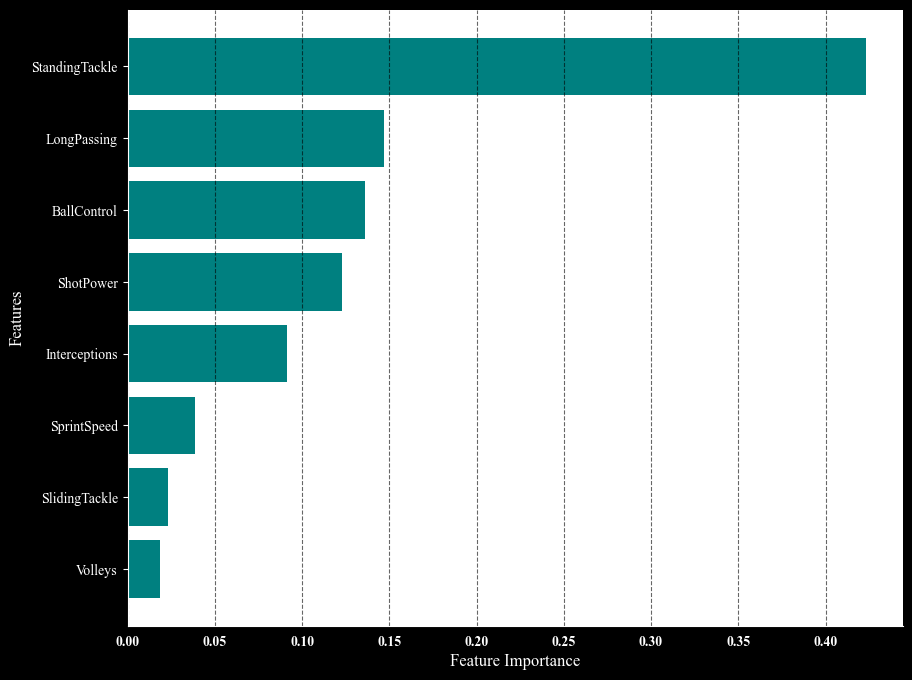

100%|██████████| 30/30 [00:02<00:00, 11.16it/s]


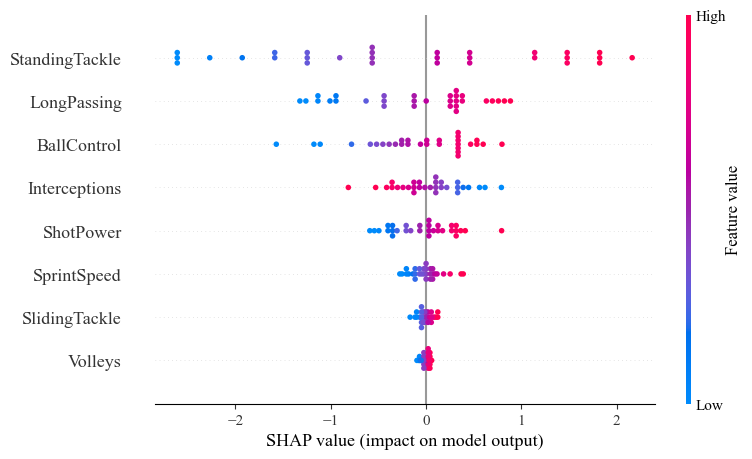

              precision    recall  f1-score   support

       False       0.89      1.00      0.94        49
        True       1.00      0.33      0.50         9

    accuracy                           0.90        58
   macro avg       0.95      0.67      0.72        58
weighted avg       0.91      0.90      0.87        58

Huber Regression training----->


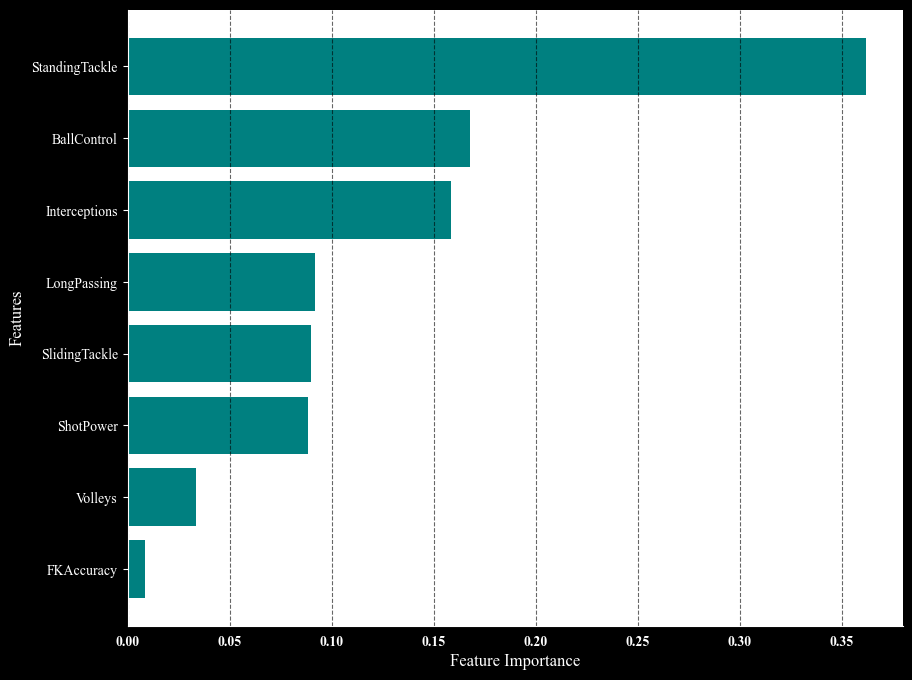

100%|██████████| 30/30 [00:03<00:00,  8.83it/s]


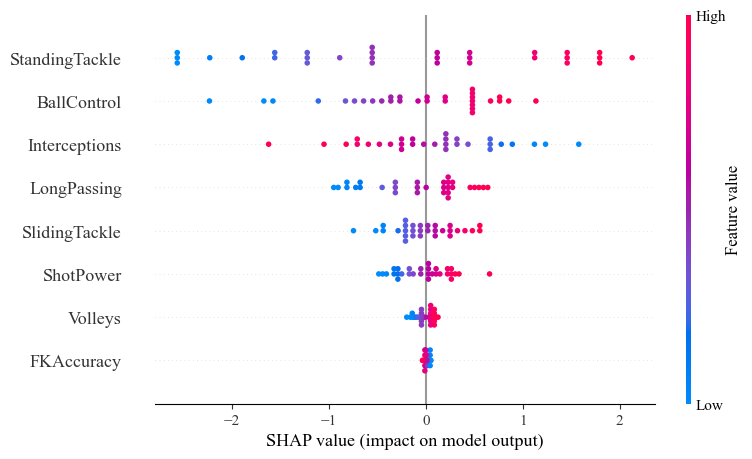

              precision    recall  f1-score   support

       False       0.89      1.00      0.94        49
        True       1.00      0.33      0.50         9

    accuracy                           0.90        58
   macro avg       0.95      0.67      0.72        58
weighted avg       0.91      0.90      0.87        58

Linear Regression training----->


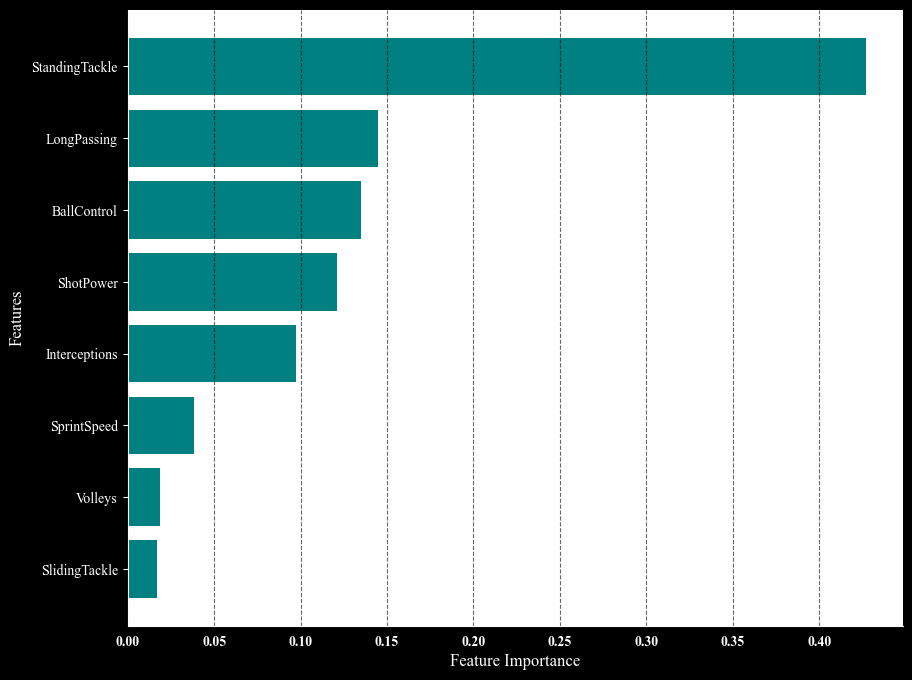

100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


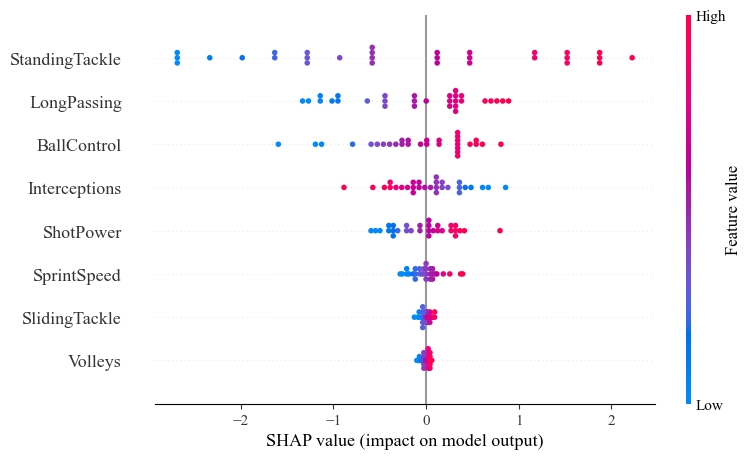

              precision    recall  f1-score   support

       False       0.89      1.00      0.94        49
        True       1.00      0.33      0.50         9

    accuracy                           0.90        58
   macro avg       0.95      0.67      0.72        58
weighted avg       0.91      0.90      0.87        58

Model: Ridge Regression
Mean Squared Error: 24.28
Mean Absolute Error: 4.03
R2 Score: 0.30

Model: Huber Regression
Mean Squared Error: 24.31
Mean Absolute Error: 4.00
R2 Score: 0.30

Model: Linear Regression
Mean Squared Error: 24.26
Mean Absolute Error: 4.03
R2 Score: 0.30



In [64]:



regression_models = {
    'Ridge Regression': Ridge(**PARAMS_RIDGE),
    'Huber Regression':HuberRegressor(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    # 'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
    # 'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
    # 'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}

# Set the experiment name

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        features = select_features(method=AUTO_FEATURE_SELECT,X=X_train_scaled_df,y=y_train,model=model)
        
        model.fit(X_train_scaled_df[features], y_train)
        y_pred = model.predict(X_test_scaled_df[features])
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(features),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df[features])
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        explainer = plot_shap_summary(model=model,df=X_test_scaled_df[features],K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        

        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'explainer':explainer,
            'attributes': features,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [65]:

if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [66]:
X_train.describe()

,HeadingAccuracy,ShortPassing,Volleys,FKAccuracy,LongPassing,BallControl,SprintSpeed,Agility,Composure,Defense,ShotPower,Strength,Aggression,Interceptions,StandingTackle,SlidingTackle
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.00000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,70.382550,62.637584,33.026846,34.711409,56.979866,59.583893,67.09396,56.550336,29.946309,70.711409,52.677852,75.845638,69.060403,69.389262,73.140940,70.234899
std,6.668398,7.948495,9.588807,11.225150,11.042589,9.793200,7.99860,10.384133,30.468368,6.101944,12.211132,7.248229,8.616631,7.555838,5.886333,6.384514
min,54.000000,38.000000,11.000000,20.000000,26.000000,34.000000,34.00000,29.000000,0.000000,54.000000,27.000000,58.000000,42.000000,50.000000,58.000000,54.000000
25%,66.000000,58.000000,28.000000,28.000000,49.000000,52.000000,63.00000,49.000000,0.000000,66.000000,44.000000,71.000000,65.000000,65.000000,69.000000,66.000000
50%,70.000000,64.000000,32.000000,32.000000,58.000000,62.000000,68.00000,57.000000,41.000000,71.000000,50.000000,76.000000,70.000000,71.000000,74.000000,71.000000
75%,75.000000,68.000000,36.000000,38.000000,65.000000,66.000000,73.00000,64.000000,59.000000,75.000000,61.000000,81.000000,74.000000,75.000000,77.000000,74.000000
max,86.000000,78.000000,71.000000,77.000000,79.000000,76.000000,83.00000,79.000000,78.000000,86.000000,82.000000,94.000000,91.000000,86.000000,88.000000,86.000000


In [67]:
y_test.describe()

count    58.000000
mean     74.000000
std       5.953033
min      61.000000
25%      70.250000
50%      74.000000
75%      77.000000
max      89.000000
Name: target, dtype: float64

In [68]:
my_model = regression_results['Huber Regression']['Model']
my_features = regression_results['Huber Regression']['attributes']


In [69]:
result_df = pd.Series(my_model.predict(X_test_scaled_df[my_features]),index=X_test_scaled_df.index)
len(result_df)

58

<Axes: >

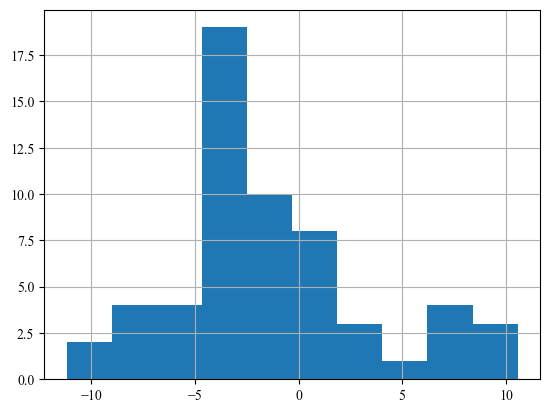

In [70]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

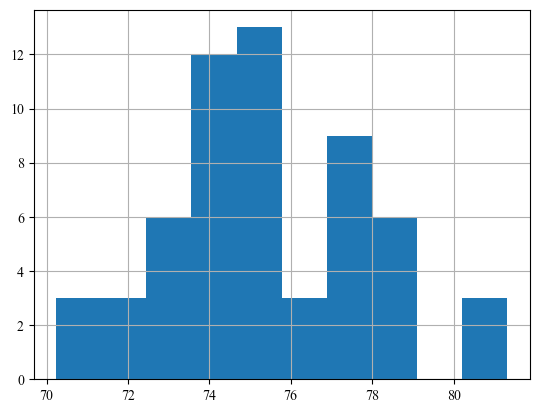

In [71]:
result_df.sort_values(ascending=False).hist()

In [72]:
(y_test-result_df).describe()

count    58.000000
mean     -1.371432
std       4.777426
min     -11.193022
25%      -3.861448
50%      -2.464928
75%       0.963971
max      10.568040
dtype: float64

In [73]:
outlier = (y_test-result_df)>3
X_test[outlier]


,,,HeadingAccuracy,ShortPassing,Volleys,FKAccuracy,LongPassing,BallControl,SprintSpeed,Agility,Composure,Defense,ShotPower,Strength,Aggression,Interceptions,StandingTackle,SlidingTackle
ID,Name,FIFA,,,,,,,,,,,,,,,,
243715,W. Saliba,2020,67.0,70.0,32.0,35.0,52.0,58.0,64.0,49.0,65.0,70.0,49.0,76.0,65.0,76.0,72.0,69.0
232488,C. Romero,2020,76.0,55.0,33.0,29.0,46.0,54.0,65.0,64.0,58.0,67.0,51.0,75.0,88.0,76.0,73.0,74.0
239818,Rúben Dias,2020,82.0,71.0,30.0,26.0,58.0,63.0,64.0,48.0,79.0,84.0,74.0,79.0,92.0,76.0,83.0,77.0
232756,F. Tomori,2020,63.0,71.0,32.0,40.0,58.0,63.0,83.0,76.0,73.0,69.0,41.0,75.0,67.0,73.0,75.0,70.0
251517,J. Gvardiol,2020,62.0,56.0,23.0,23.0,43.0,54.0,77.0,56.0,54.0,55.0,56.0,80.0,76.0,56.0,62.0,61.0
247497,A. Bella-Kotchap,2020,52.0,42.0,24.0,22.0,38.0,41.0,74.0,43.0,40.0,59.0,38.0,79.0,55.0,61.0,62.0,61.0
253163,R. Araujo,2021,75.0,67.0,32.0,45.0,62.0,58.0,62.0,42.0,47.0,62.0,39.0,73.0,66.0,65.0,70.0,63.0
248484,N. Collins,2021,54.0,57.0,22.0,25.0,51.0,54.0,64.0,41.0,63.0,58.0,36.0,75.0,67.0,64.0,62.0,64.0
232580,Gabriel,2020,76.0,72.0,28.0,27.0,58.0,63.0,54.0,51.0,64.0,70.0,51.0,80.0,75.0,74.0,71.0,70.0


In [74]:
y_test[outlier]

ID      Name              FIFA
243715  W. Saliba         2020    84.0
232488  C. Romero         2020    82.0
239818  Rúben Dias        2020    89.0
232756  F. Tomori         2020    84.0
251517  J. Gvardiol       2020    82.0
247497  A. Bella-Kotchap  2020    74.0
253163  R. Araujo         2021    86.0
248484  N. Collins        2021    76.0
232580  Gabriel           2020    84.0
Name: target, dtype: float64

In [75]:
result_df[outlier]

ID      Name              FIFA
243715  W. Saliba         2020    75.287334
232488  C. Romero         2020    75.482220
239818  Rúben Dias        2020    81.314108
232756  F. Tomori         2020    77.116755
251517  J. Gvardiol       2020    72.979182
247497  A. Bella-Kotchap  2020    70.278094
253163  R. Araujo         2021    75.431960
248484  N. Collins        2021    71.842674
232580  Gabriel           2020    76.034037
dtype: float64

In [76]:
(y_test/result_df).describe()

count    58.000000
mean      0.981251
std       0.064115
min       0.844957
25%       0.947910
50%       0.967334
75%       1.012740
max       1.140100
dtype: float64

In [77]:
(y_test/result_df).describe()

count    58.000000
mean      0.981251
std       0.064115
min       0.844957
25%       0.947910
50%       0.967334
75%       1.012740
max       1.140100
dtype: float64

In [78]:
np.corrcoef(y_test,result_df)

array([[1.        , 0.63239113],
       [0.63239113, 1.        ]])

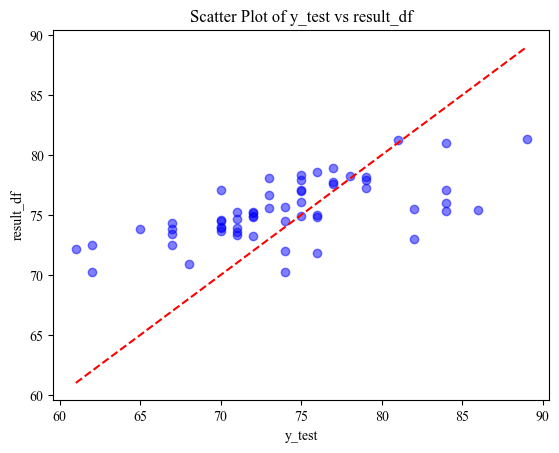

In [79]:

plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [80]:
result_df = result_df.sort_values(ascending=False)

In [81]:
result_df.head(50)

ID      Name             FIFA
239818  Rúben Dias       2020    81.314108
247263  E. Tapsoba       2021    81.231766
239301  L. Martínez      2020    81.001741
229942  A. Disasi        2021    78.943860
233885  E. Cömert        2021    78.601622
236636  A. Caci          2020    78.337671
232938  T. Tomiyasu      2020    78.246260
243854  M. Simakan       2021    78.159923
252961  T. Kouassi       2021    78.063644
238370  M. Pongračić     2020    77.946385
248695  W. Fofana        2021    77.871937
245037  Eric García      2021    77.752980
235658  V. Nelsson       2020    77.553897
245388  J. Todibo        2020    77.272204
232756  F. Tomori        2020    77.116755
244523  Javi Hernández   2020    77.075455
246565  B. Diakité       2021    77.064509
246352  Guillamón        2021    76.980962
222428  J. Komar         2020    76.690984
233926  Léo Duarte       2020    76.094492
232580  Gabriel          2020    76.034037
236600  J. Tanganga      2021    75.640719
229682  D. Fry          

In [82]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

3


ID      Name         FIFA
239818  Rúben Dias   2020    81.314108
247263  E. Tapsoba   2021    81.231766
239301  L. Martínez  2020    81.001741
dtype: float64

In [83]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

6


ID      Name         FIFA
232756  F. Tomori    2020    77.116755
232580  Gabriel      2020    76.034037
232488  C. Romero    2020    75.482220
253163  R. Araujo    2021    75.431960
243715  W. Saliba    2020    75.287334
251517  J. Gvardiol  2020    72.979182
dtype: float64

In [84]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

0


Series([], dtype: float64)

In [85]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

49


ID      Name            FIFA
243497  S. Walukiewicz  2020    75.263022
244349  J. Vásquez      2021    75.269226
229682  D. Fry          2020    75.570858
236600  J. Tanganga     2021    75.640719
233926  Léo Duarte      2020    76.094492
222428  J. Komar        2020    76.690984
246352  Guillamón       2021    76.980962
246565  B. Diakité      2021    77.064509
244523  Javi Hernández  2020    77.075455
245388  J. Todibo       2020    77.272204
235658  V. Nelsson      2020    77.553897
245037  Eric García     2021    77.752980
248695  W. Fofana       2021    77.871937
238370  M. Pongračić    2020    77.946385
252961  T. Kouassi      2021    78.063644
243854  M. Simakan      2021    78.159923
232938  T. Tomiyasu     2020    78.246260
236636  A. Caci         2020    78.337671
233885  E. Cömert       2021    78.601622
229942  A. Disasi       2021    78.943860
dtype: float64

In [86]:

print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.72      0.55      0.63        38
        True       0.41      0.60      0.49        20

    accuracy                           0.57        58
   macro avg       0.57      0.58      0.56        58
weighted avg       0.62      0.57      0.58        58

